https://github.com/ismailuddin/gradcam-tensorflow-2/blob/master/notebooks/GradCam.ipynb

# Download Datset

## From Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"chichiu","key":"732817920bd9156766eace20dd14bbcb"}'}

In [ ]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

 97% 190M/195M [00:05<00:00, 49.2MB/s]
100% 195M/195M [00:05<00:00, 34.6MB/s]


In [ ]:
!unzip -u "/content/breast-ultrasound-images-dataset.zip" -d "./"

# Preprocessing

In [ ]:
import tensorflow as tf
import pandas as pd 
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt 
import os 
import pathlib 
import random

In [ ]:
path = "/content/Breast Ultrasound Images Dataset/Dataset_BUSI_with_GT"
data_dir = pathlib.Path(path)

In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['benign', 'malignant', 'normal'], dtype='<U9')

In [ ]:
# import shutil

# shutil.rmtree('/content/Breast Ultrasound Images Dataset')

In [ ]:
benignPath = os.path.join(data_dir,'benign')
malignantPath = os.path.join(data_dir,'malignant')
normalPath = os.path.join(data_dir,'normal')
imageCount = len(list(data_dir.glob('*/*.png')))
print('Number of Image:',imageCount)

Number of Image: 780


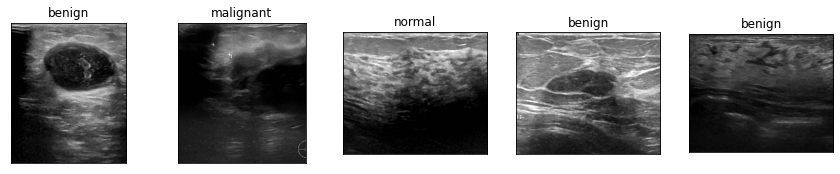

In [ ]:
plt.figure(figsize=(15,15))

for i in range(5):
    plt.subplot(5,5,i+1)
    random_class = random.choice(class_names)
    img = plt.imread(random.choice(list(data_dir.glob(random_class+"/*.png"))))
    plt.xticks([])
    plt.yticks([])
    plt.title(random_class)
    plt.imshow(img)

## Check image type

In [ ]:
from pathlib import Path
import imghdr

data_dir = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
data_dir = "/content/Breast Ultrasound Images Dataset/Dataset_BUSI_with_GT"

image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

## Split dataset

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
# batch_size = 32
# img_height = 224
# img_width = 224
# img_channels = 3
batch_size = 36
img_height = 224
img_width = 224
img_channels = 3 # 3
validation_split = 0.25
train_data = image_dataset_from_directory(
                  data_dir,
                  label_mode = 'categorical',
                  validation_split=validation_split,
                  subset="training",
                  seed=123,
                  image_size=(img_height, img_width),
                  batch_size=batch_size)


val_data = image_dataset_from_directory(data_dir,
                  label_mode = 'categorical',
                  validation_split=validation_split,
                  subset="validation",
                  seed=123,
                  image_size=(img_height,img_width),
                  batch_size=batch_size)

Found 780 files belonging to 3 classes.
Using 585 files for training.
Found 780 files belonging to 3 classes.
Using 195 files for validation.


In [ ]:
#  print(train_data)

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


In [ ]:
# for inp,label in train_data.take(1):
#   print(label)

# Another TL API

In [ ]:
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import (
    ResNet50,
    preprocess_input,
    decode_predictions,
)
import cv2

In [ ]:
image = np.array(load_img("../data/cat.jpg", target_size=(224, 224, 3)))
plt.imshow(image)

In [ ]:
model = ResNet50()
last_conv_layer = model.get_layer("conv5_block3_out")
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ["avg_pool", "predictions"]:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

In [ ]:
with tf.GradientTape() as tape:
    inputs = image[np.newaxis, ...]
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [ ]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [ ]:
# Average over all the filters to get a single 2D array
gradcam = np.mean(last_conv_layer_output, axis=-1)
# Clip the values (equivalent to applying ReLU)
# and then normalise the values
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
gradcam = cv2.resize(gradcam, (224, 224))

In [ ]:
plt.imshow(image)
plt.imshow(gradcam, alpha=0.5)

# Build Model

In [ ]:
import urllib
from IPython.display import Markdown as md

In [ ]:
import tensorflow_hub as hub
import os

In [ ]:
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
lrate = 1e-4
num_hidden = 4096
l1 = 0
l2 = 0
epochs = 20

## Transfer Learning

In [ ]:
import keras

In [ ]:
DO_FIINE_TUNING = True

In [ ]:
regularizer = tf.keras.regularizers.l1_l2(l1, l2)
layers = [
    # hub.KerasLayer(
    #     "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
    #     input_shape=(img_height, img_width, img_channels),
    #     trainable=False,
    #     name='mobilenet_embedding'),
    hub.KerasLayer(
        "https://tfhub.dev/tensorflow/resnet_50/classification/1",
        input_shape=(img_height, img_width, img_channels),
        trainable=DO_FIINE_TUNING,
        name='ResNet50'),
        
    tf.keras.layers.Dense(num_hidden,
        kernel_regularizer=regularizer, 
        activation='relu',
        name='dense_hidden'),
    tf.keras.layers.Dense(len(class_names), 
        kernel_regularizer=regularizer,
        activation='softmax', # sigmoid
        name='flower_prob')
  ]

model = tf.keras.Sequential(layers, name='breast_cancer_classification')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
              loss=tf.keras.losses.CategoricalCrossentropy( # BinaryCrossentropy
                  from_logits=False),
              metrics=['Accuracy',keras.metrics.Precision(), keras.metrics.Recall(),
                       tf.keras.metrics.AUC(from_logits=False)])#'F1'])
print(model.summary())

Model: "breast_cancer_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ResNet50 (KerasLayer)       (None, 1001)              25612201  
                                                                 
 dense_hidden (Dense)        (None, 4096)              4104192   
                                                                 
 flower_prob (Dense)         (None, 3)                 12291     
                                                                 
Total params: 29,728,684
Trainable params: 29,675,564
Non-trainable params: 53,120
_________________________________________________________________
None


## self-built model

In [ ]:
# from tensorflow.keras import layers 
# model = tf.keras.Sequential([
#   layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
    
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
    
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
    
#   layers.Dropout(0.5),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(3,activation="softmax")
# ])

In [ ]:
# model.compile(optimizer="Adam",
#             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#             metrics=["accuracy"])

## Training

In [ ]:
history = model.fit(train_data,
          epochs=epochs,
          validation_data=val_data, 
          batch_size=batch_size)

Epoch 1/20
17/17 [==============================] - 41s 755ms/step - loss: 1.5335 - Accuracy: 0.5231 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6774 - val_loss: 1.4945 - val_Accuracy: 0.5590 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7786
Epoch 2/20
17/17 [==============================] - 10s 486ms/step - loss: 1.4529 - Accuracy: 0.5607 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7936 - val_loss: 1.4091 - val_Accuracy: 0.5590 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8296
Epoch 3/20
17/17 [==============================] - 10s 488ms/step - loss: 1.3575 - Accuracy: 0.5607 - precision: 0.8917 - recall: 0.1829 - auc: 0.8475 - val_loss: 1.3248 - val_Accuracy: 0.5590 - val_precision: 0.9114 - val_recall: 0.3692 - val_auc: 0.8478
Epoch 4/20
17/17 [==============================] - 10s 490ms/step - loss: 1.2555 - Accuracy: 0.5607 - precision: 0.9252 - recall: 0.5077 - auc: 0.8706 - val_loss: 1.2374 - val_Accuracy: 0.5590 - v

In [ ]:
model.summary()

Model: "breast_cancer_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ResNet50 (KerasLayer)       (None, 1001)              25612201  
                                                                 
 dense_hidden (Dense)        (None, 4096)              4104192   
                                                                 
 flower_prob (Dense)         (None, 3)                 12291     
                                                                 
Total params: 29,728,684
Trainable params: 29,675,564
Non-trainable params: 53,120
_________________________________________________________________


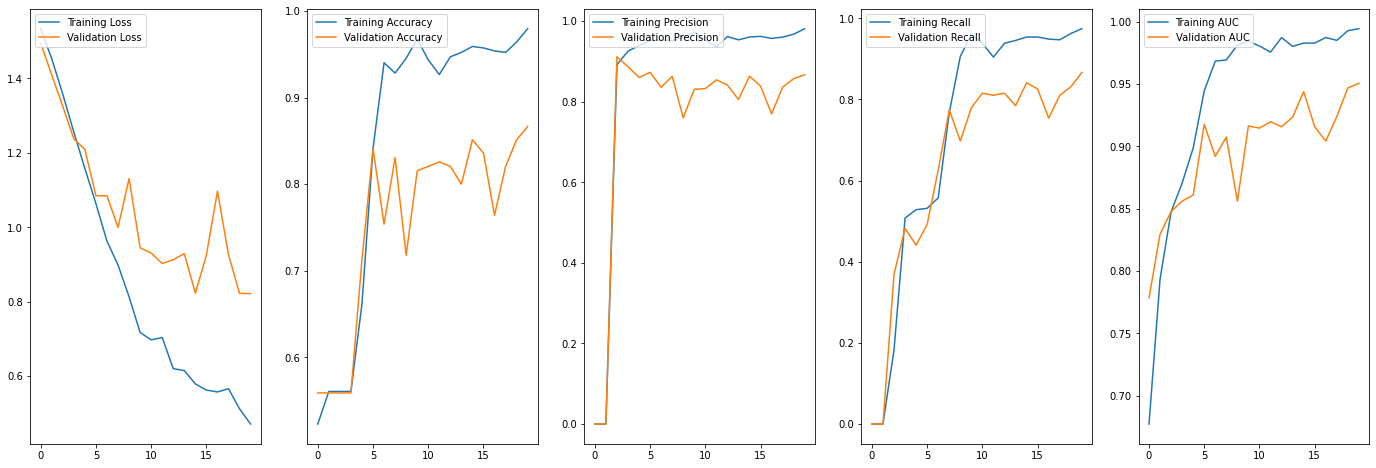

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['Accuracy']
val_acc =  history.history['val_Accuracy']

precision = history.history['precision']
val_precision =  history.history['val_precision']

recall = history.history['recall']
val_recall =  history.history['val_recall']

auc = history.history['auc']
val_auc =  history.history['val_auc']

epochs_range = range(epochs)

plt.figure(figsize=(24,8))

plt.subplot(1,5,1)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.legend(loc = "upper left")

plt.subplot(1,5,2)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend(loc = "upper left")

plt.subplot(1,5,3)
plt.plot(epochs_range,precision,label='Training Precision')
plt.plot(epochs_range,val_precision,label="Validation Precision")
plt.legend(loc = "upper left")

plt.subplot(1,5,4)
plt.plot(epochs_range,recall,label='Training Recall')
plt.plot(epochs_range,val_recall,label="Validation Recall")
plt.legend(loc = "upper left")

plt.subplot(1,5,5)
plt.plot(epochs_range,auc,label='Training AUC')
plt.plot(epochs_range,val_auc,label="Validation AUC")
plt.legend(loc = "upper left")
plt.show()


In [ ]:
print('%.4f' %max(val_acc))
print('%.4f' %max(val_precision))
print('%.4f' %max(val_recall))
print('%.3f' %max(val_auc))

0.8667
0.9114
0.8667
0.951


# Prediction

In [ ]:
plt.figure(figsize=(15, 15))
class_names = val_data.class_names
result = ' | False'
for images, labels in val_data.take(1):
    for i in range(25):
        
        ax = plt.subplot(5, 5, i + 1)
        img = images[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)
        
        predictions = model.predict(img)
        predicted_class = np.argmax(predictions)
        if class_names[predicted_class] == class_names[labels[i]]:
            result = ' | TRUE'
            
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]]+' | '+ class_names[predicted_class] )
        plt.axis("off")